Estimating **heterogeneous treatment effects** using Causal Forests and Meta-Learners in Python.

In causal inference, we often focus on estimating the **Average Treatment Effect (ATE)** — the mean impact of a treatment across an entire population. But in practice, treatment effects are rarely uniform. A marketing campaign might boost sales for price-sensitive customers while having no effect on loyal ones. A medical treatment might work well for younger patients but not for older ones.

The **Conditional Average Treatment Effect (CATE)** captures this heterogeneity:

$$
\tau(x) = \mathbb{E}[Y_i(1) - Y_i(0) \mid X_i = x]
$$

where $Y_i(1)$ and $Y_i(0)$ are the potential outcomes under treatment and control, and $X_i$ is a vector of covariates. Estimating $\tau(x)$ allows us to answer: *who benefits most from the treatment?*

In this post, we explore several modern approaches to CATE estimation:

1. **Meta-Learners** (S-Learner, T-Learner, X-Learner) — simple strategies that repurpose standard ML models for causal estimation.
2. **Causal Forests** (Athey & Imbens, 2018; Wager & Athey, 2018) — an ensemble method specifically designed for heterogeneous treatment effect estimation.

We start with **simulated data** where the true CATE is known, allowing us to visually compare how well each method recovers the treatment effect surface. Later, we apply these methods to a real-world dataset.

# 1. Simulation Study

To benchmark our estimators, we begin with a controlled simulation where the true treatment effect function $\tau(x)$ is known by construction. This allows us to directly compare estimated CATEs against the ground truth.

## 1.1. Setup

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.interpolate import griddata

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

from econml.dml import CausalForestDML
from econml.metalearners import SLearner, TLearner, XLearner

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

## 1.2. Data Generating Process

We follow a simulation design inspired by [Athey & Imbens (2016)](https://doi.org/10.1073/pnas.1510489113) and [Aeturrell](https://aeturrell.com/blog/posts/estimation-heterogeneous-treatment-random-forests/). The setup is:

- **Covariates**: $X_i \in \mathbb{R}^6$, drawn from $\text{Uniform}[0, 1]^6$. Only the first two covariates ($X_0, X_1$) drive the treatment effect; the remaining four are **noise**.
- **Treatment assignment**: $W_i \sim \text{Bernoulli}(e(X_i))$ where the propensity score is:

$$
e(x) = 0.25 \cdot (1 + \beta_{2,4}(x_0))
$$

  with $\beta_{2,4}$ denoting the CDF of a $\text{Beta}(2, 4)$ distribution. This creates a **non-uniform propensity** that depends on $X_0$, making the problem more realistic.

- **Baseline outcome** (control potential outcome):

$$
\mu_0(x) = 2X_0 - 1
$$

- **Treatment effect** (CATE):

$$
\tau(x) = \zeta(X_0) \cdot \zeta(X_1)
$$

where $\zeta$ is a sigmoid-like function:

$$
\zeta(x) = 1 + \frac{1}{1 + e^{-20(x - 1/3)}}
$$

This creates a **nonlinear CATE surface** that ranges from approximately 1 (when both $X_0$ and $X_1$ are small) to 4 (when both are large), with a sharp transition around $x = 1/3$.

- **Observed outcome**:

$$
Y_i = \mu_0(X_i) + \tau(X_i) \cdot W_i + \varepsilon_i, \quad \varepsilon_i \sim \mathcal{N}(0, 1)
$$

In [43]:
from scipy.stats import beta as beta_dist

def zeta(x):
    """Sigmoid-like function for CATE surface."""
    return 1 + 1 / (1 + np.exp(-20 * (x - 1/3)))

def true_cate(X):
    """True CATE: tau(x) = zeta(X0) * zeta(X1)."""
    return zeta(X[:, 0]) * zeta(X[:, 1])

def generate_data(n=5000, d=6, seed=42):
    """Generate simulation data with heterogeneous treatment effects."""
    rng = np.random.default_rng(seed)
    
    # Covariates: Uniform[0,1]^d
    X = rng.uniform(0, 1, size=(n, d))
    
    # Propensity score: depends on X0
    e_x = 0.25 * (1 + beta_dist.cdf(X[:, 0], 2, 4))
    
    # Treatment assignment
    W = rng.binomial(1, e_x)
    
    # Baseline outcome
    mu_0 = 2 * X[:, 0] - 1
    
    # True treatment effect
    tau = true_cate(X)
    
    # Observed outcome
    epsilon = rng.normal(0, 1, n)
    Y = mu_0 + tau * W + epsilon
    
    return X, W, Y, tau, e_x

# Generate data
n = 5000
X, W, Y, tau_true, e_x = generate_data(n=n)

print(f"Sample size: {n}")
print(f"Treated: {W.sum()} ({W.mean():.1%})")
print(f"Control: {n - W.sum()} ({1 - W.mean():.1%})")
print(f"True ATE: {tau_true.mean():.3f}")

Sample size: 5000
Treated: 2067 (41.3%)
Control: 2933 (58.7%)
True ATE: 2.774


## 1.3. True CATE Surface

Before estimating anything, let's visualize the **true** treatment effect surface. Since $\tau(x)$ only depends on $X_0$ and $X_1$, we can plot it as a heatmap:

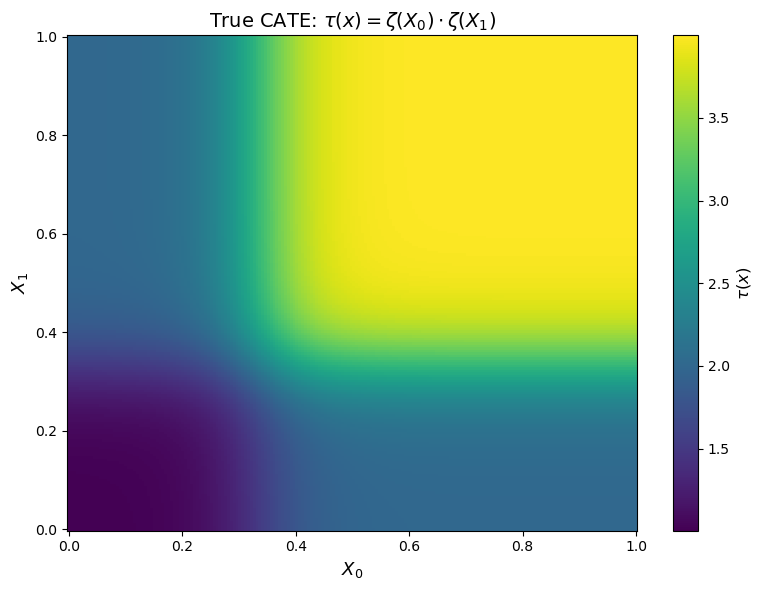

In [44]:
#| label: fig-true-cate
#| fig-cap: "True CATE surface $\\tau(x) = \\zeta(X_0) \\cdot \\zeta(X_1)$. The treatment effect ranges from ~1 (low $X_0$, low $X_1$) to ~4 (high $X_0$, high $X_1$), with a sharp transition around $x = 1/3$."
#| code-fold: true

# Create grid for true CATE
grid_n = 200
x0_grid = np.linspace(0, 1, grid_n)
x1_grid = np.linspace(0, 1, grid_n)
X0_mesh, X1_mesh = np.meshgrid(x0_grid, x1_grid)

# Compute true CATE on grid
X_grid = np.column_stack([X0_mesh.ravel(), X1_mesh.ravel()])
tau_grid = zeta(X_grid[:, 0]) * zeta(X_grid[:, 1])
tau_mesh = tau_grid.reshape(grid_n, grid_n)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.pcolormesh(X0_mesh, X1_mesh, tau_mesh, cmap='viridis', shading='auto')
ax.set_xlabel('$X_0$', fontsize=13)
ax.set_ylabel('$X_1$', fontsize=13)
ax.set_title('True CATE: $\\tau(x) = \\zeta(X_0) \\cdot \\zeta(X_1)$', fontsize=14)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('$\\tau(x)$', fontsize=12)
plt.tight_layout()
plt.show()

The heatmap reveals the key feature of our DGP: the treatment effect is **strongly heterogeneous**. Individuals in the upper-right region ($X_0 > 1/3$, $X_1 > 1/3$) experience a treatment effect close to 4, while those in the lower-left region see an effect close to 1. The sigmoid function creates a sharp "elbow" around $X_0 = X_1 = 1/3$.

This is the surface that our estimators will try to recover.

# 2. CATE Estimation Methods

We now estimate the CATE using four different approaches. Each takes the same data $(X, W, Y)$ and produces an estimate $\hat{\tau}(x)$ for every observation.

All implementations use the [`econml`](https://econml.azurewebsites.net/) package from Microsoft Research.

## 2.1. S-Learner

The **S-Learner** (Single Learner) is the simplest meta-learner. It fits a single model $\hat{\mu}(X, W)$ on the full dataset, including the treatment indicator as a feature:

$$
\hat{\tau}^S(x) = \hat{\mu}(x, 1) - \hat{\mu}(x, 0)
$$

The CATE estimate is the difference in predictions when we toggle the treatment indicator. The main drawback is **regularization bias**: if the treatment effect is small relative to the main effects, the model may learn to ignore $W$ entirely.

In [45]:
# S-Learner
s_learner = SLearner(
    overall_model=GradientBoostingRegressor(
        n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42
    )
)
s_learner.fit(Y, W, X=X)
tau_hat_s = s_learner.effect(X).flatten()

print(f"S-Learner — Estimated ATE: {tau_hat_s.mean():.3f} (True: {tau_true.mean():.3f})")

S-Learner — Estimated ATE: 2.755 (True: 2.774)


## 2.2. T-Learner

The **T-Learner** (Two Learner) fits separate models for the treated and control groups:

$$
\hat{\mu}_1(x) = \mathbb{E}[Y \mid X = x, W = 1], \quad \hat{\mu}_0(x) = \mathbb{E}[Y \mid X = x, W = 0]
$$

$$
\hat{\tau}^T(x) = \hat{\mu}_1(x) - \hat{\mu}_0(x)
$$

This avoids the regularization bias of the S-Learner but can suffer from **high variance** when sample sizes are small, since each model only sees half the data.

In [46]:
# T-Learner
t_learner = TLearner(
    models=[
        GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42),
        GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42),
    ]
)
t_learner.fit(Y, W, X=X)
tau_hat_t = t_learner.effect(X).flatten()

print(f"T-Learner — Estimated ATE: {tau_hat_t.mean():.3f} (True: {tau_true.mean():.3f})")

T-Learner — Estimated ATE: 2.778 (True: 2.774)


## 2.3. X-Learner

The **X-Learner** ([Künzel et al., 2019](https://doi.org/10.1073/pnas.1804597116)) improves on the T-Learner by using **cross-imputation**: it imputes the missing potential outcomes for each group using the other group's model, then fits a second-stage model on these imputed treatment effects:

**Step 1**: Fit $\hat{\mu}_0$ and $\hat{\mu}_1$ as in the T-Learner.

**Step 2**: Impute individual treatment effects:
$$
\tilde{\tau}_1^i = Y_i^1 - \hat{\mu}_0(X_i^1), \quad \tilde{\tau}_0^i = \hat{\mu}_1(X_i^0) - Y_i^0
$$

**Step 3**: Fit models $\hat{\tau}_1(x)$ and $\hat{\tau}_0(x)$ on these imputed effects.

**Step 4**: Combine using the propensity score:
$$
\hat{\tau}^X(x) = e(x) \cdot \hat{\tau}_0(x) + (1 - e(x)) \cdot \hat{\tau}_1(x)
$$

The X-Learner is particularly effective when one group is much larger than the other.

In [47]:
# X-Learner
x_learner = XLearner(
    models=[
        GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42),
        GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42),
    ],
    cate_models=[
        GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42),
        GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42),
    ],
    propensity_model=GradientBoostingClassifier(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42),
)
x_learner.fit(Y, W, X=X)
tau_hat_x = x_learner.effect(X).flatten()

print(f"X-Learner — Estimated ATE: {tau_hat_x.mean():.3f} (True: {tau_true.mean():.3f})")

X-Learner — Estimated ATE: 2.780 (True: 2.774)


## 2.4. Causal Forest

**Causal Forests** ([Wager & Athey, 2018](https://doi.org/10.1080/01621459.2017.1319839)) are an extension of random forests specifically designed for treatment effect estimation. The key innovation is that trees split to **maximize heterogeneity in the treatment effect**, not just to improve prediction.

We use the `CausalForestDML` implementation from `econml`, which combines the causal forest with **double/debiased machine learning** (DML). This involves:

1. **First stage**: Estimate nuisance parameters $\hat{\mu}(x) = \mathbb{E}[Y|X]$ and $\hat{e}(x) = \mathbb{E}[W|X]$ using flexible ML models.
2. **Second stage**: Fit a causal forest on the **residualized** outcome $\tilde{Y} = Y - \hat{\mu}(X)$ and **residualized** treatment $\tilde{W} = W - \hat{e}(X)$.

This orthogonalization step provides **doubly robust** estimates: the CATE estimate is consistent if *either* the outcome model or the propensity model is correctly specified.

In [48]:
# Causal Forest (DML)
cf = CausalForestDML(
    model_y=GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42),
    model_t=GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42),
    n_estimators=500,
    min_samples_leaf=5,
    max_depth=None,
    random_state=42,
)
cf.fit(Y, W, X=X)
tau_hat_cf = cf.effect(X).flatten()

print(f"Causal Forest — Estimated ATE: {tau_hat_cf.mean():.3f} (True: {tau_true.mean():.3f})")

Causal Forest — Estimated ATE: 2.710 (True: 2.774)


# 3. Results

## 3.1. Estimated CATE Surfaces

We now compare how each method recovers the true CATE surface. For each estimator, we interpolate the predicted $\hat{\tau}(x)$ onto a grid over $(X_0, X_1)$ and plot the heatmap alongside the ground truth:

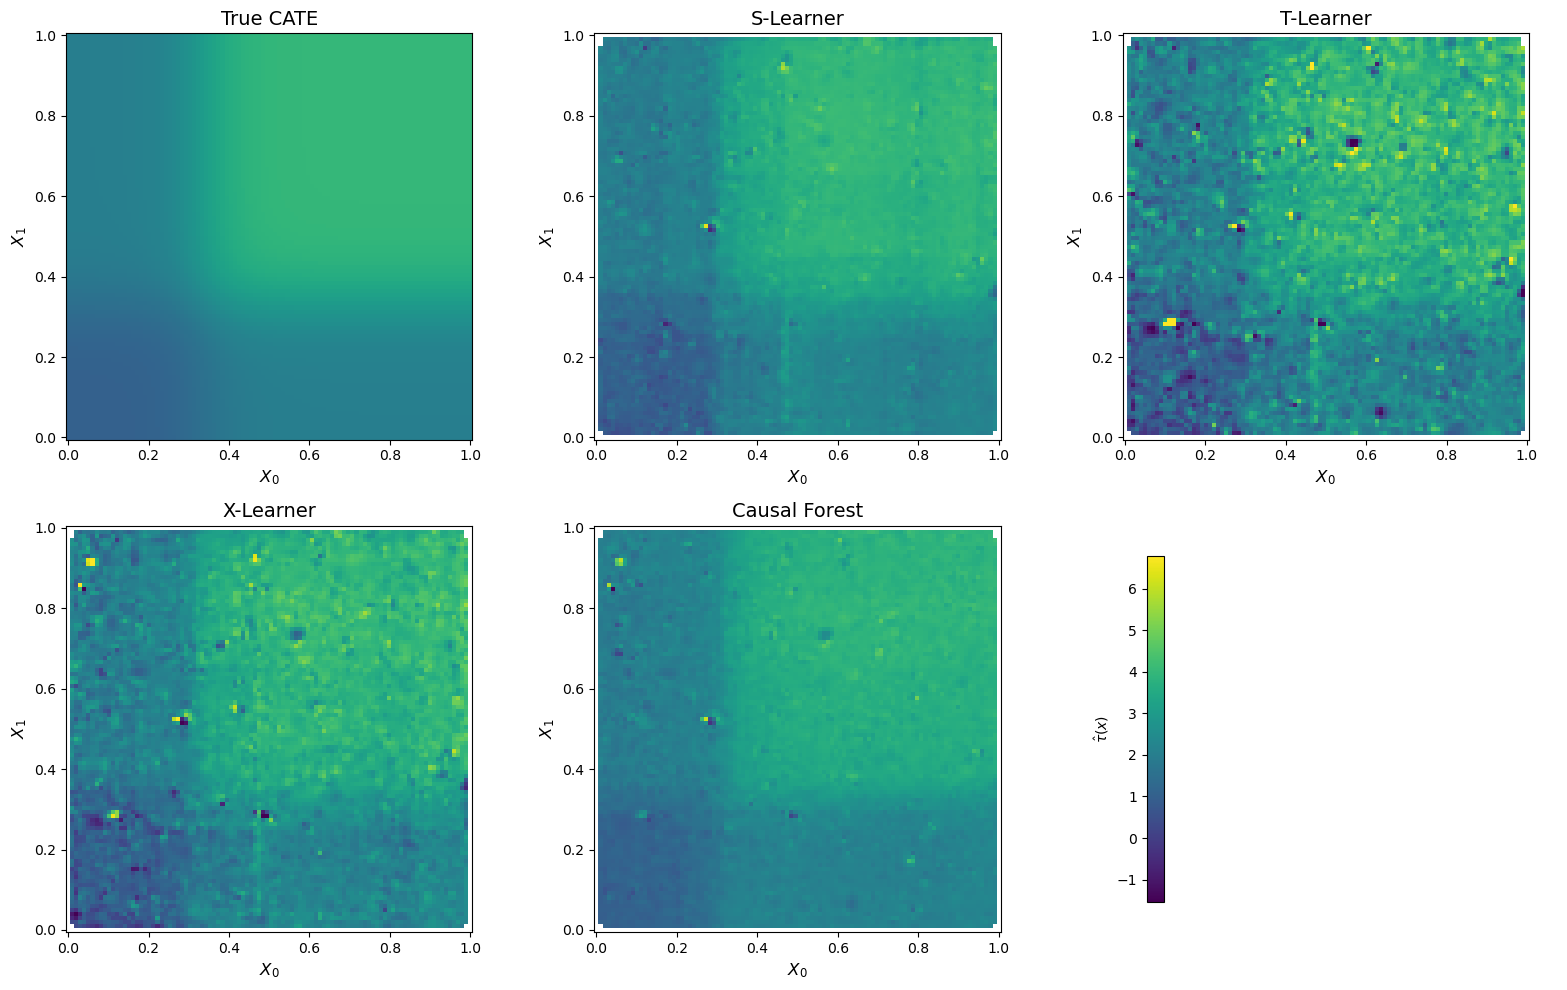

In [49]:
#| label: fig-cate-comparison
#| fig-cap: "Estimated CATE surfaces from each method compared to the true CATE. The S-Learner and Causal Forest best capture the sharp transition in the treatment effect surface."
#| code-fold: true

def interpolate_cate(X, tau_hat, grid_n=100):
    """Interpolate CATE estimates onto a regular grid over (X0, X1)."""
    x0_grid = np.linspace(0, 1, grid_n)
    x1_grid = np.linspace(0, 1, grid_n)
    X0_mesh, X1_mesh = np.meshgrid(x0_grid, x1_grid)
    tau_mesh = griddata(
        X[:, :2], tau_hat, (X0_mesh, X1_mesh), method='cubic', fill_value=np.nan
    )
    return X0_mesh, X1_mesh, tau_mesh

# Compute true CATE on finer grid
grid_n = 100
x0_g = np.linspace(0, 1, grid_n)
x1_g = np.linspace(0, 1, grid_n)
X0_g, X1_g = np.meshgrid(x0_g, x1_g)
X_g = np.column_stack([X0_g.ravel(), X1_g.ravel()])
tau_true_grid = (zeta(X_g[:, 0]) * zeta(X_g[:, 1])).reshape(grid_n, grid_n)

# Interpolate estimated CATEs
estimates = {
    'True CATE': (X0_g, X1_g, tau_true_grid),
    'S-Learner': interpolate_cate(X, tau_hat_s, grid_n),
    'T-Learner': interpolate_cate(X, tau_hat_t, grid_n),
    'X-Learner': interpolate_cate(X, tau_hat_x, grid_n),
    'Causal Forest': interpolate_cate(X, tau_hat_cf, grid_n),
}

# Global color limits
vmin = min(tau_true.min(), tau_hat_s.min(), tau_hat_t.min(), tau_hat_x.min(), tau_hat_cf.min())
vmax = max(tau_true.max(), tau_hat_s.max(), tau_hat_t.max(), tau_hat_x.max(), tau_hat_cf.max())

# Plot: 2x3 grid (5 panels + 1 empty for colorbar)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes_flat = axes.flatten()

for idx, (title, (X0_m, X1_m, tau_m)) in enumerate(estimates.items()):
    ax = axes_flat[idx]
    im = ax.pcolormesh(X0_m, X1_m, tau_m, cmap='viridis', shading='auto', vmin=vmin, vmax=vmax)
    ax.set_xlabel('$X_0$', fontsize=12)
    ax.set_ylabel('$X_1$', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_aspect('equal')

# Remove empty subplot, use it for colorbar
axes_flat[5].axis('off')
fig.colorbar(im, ax=axes_flat[5], shrink=0.85, label='$\\hat{\\tau}(x)$', location='left')

plt.tight_layout()
plt.show()

@fig-cate-comparison reveals striking differences across methods. The **S-Learner** and the **Causal Forest** produce the smoothest and most faithful reconstructions of the true CATE surface — both clearly recover the characteristic "L-shaped" transition around $X_0 = X_1 = 1/3$.

In contrast, the **T-Learner** surface is visibly noisy. Because the T-Learner fits entirely separate models for the treated and control groups, each model only trains on a subset of the data (~2,000 and ~3,000 observations respectively). The CATE is then obtained by *subtracting* two noisy predictions, which amplifies estimation error — a well-known variance issue with this approach.

The **X-Learner** falls in between: it captures the general shape of the CATE surface better than the T-Learner, but introduces some noise through its cross-imputation and propensity-weighting steps. Its advantage — leveraging the larger control group to improve treated-group estimates — is partially offset by the complexity of its multi-stage procedure.

## 3.2. Quantitative Comparison

Beyond visual inspection, we evaluate each estimator using two metrics:

- **MSE**: $\frac{1}{n}\sum_i (\hat{\tau}(X_i) - \tau(X_i))^2$ — measures the average squared error in CATE estimation.
- **$R^2$ (CATE)**: $1 - \frac{\sum_i(\hat{\tau}(X_i) - \tau(X_i))^2}{\sum_i(\tau(X_i) - \bar{\tau})^2}$ — measures how much of the treatment effect heterogeneity is captured.

In [50]:
#| label: tbl-metrics
#| tbl-cap: Performance of CATE Estimators (Simulation)

def cate_metrics(tau_true, tau_hat, name):
    mse = np.mean((tau_hat - tau_true) ** 2)
    ss_res = np.sum((tau_hat - tau_true) ** 2)
    ss_tot = np.sum((tau_true - tau_true.mean()) ** 2)
    r2 = 1 - ss_res / ss_tot
    ate_bias = np.abs(tau_hat.mean() - tau_true.mean())
    return {'Method': name, 'MSE': round(mse, 4), 'R² (CATE)': round(r2, 4), 'ATE Bias': round(ate_bias, 4)}

results = pd.DataFrame([
    cate_metrics(tau_true, tau_hat_s, 'S-Learner'),
    cate_metrics(tau_true, tau_hat_t, 'T-Learner'),
    cate_metrics(tau_true, tau_hat_x, 'X-Learner'),
    cate_metrics(tau_true, tau_hat_cf, 'Causal Forest'),
]).set_index('Method')

results

,MSE,R² (CATE),ATE Bias
Method,,,
S-Learner,0.0519,0.9475,0.0185
T-Learner,0.2939,0.7022,0.0038
X-Learner,0.1401,0.8580,0.0065
Causal Forest,0.0461,0.9533,0.0641


@tbl-metrics confirms the visual impression. Two key takeaways:

1. **Causal Forest achieves the best overall CATE recovery** ($R^2 = 0.95$, MSE $= 0.046$), closely followed by the S-Learner ($R^2 = 0.95$, MSE $= 0.052$). Both methods effectively capture over 95% of the variation in the true treatment effect surface.

2. **There is a bias-variance tradeoff across methods**. The T-Learner has the lowest ATE bias (0.004) — it gets the *average* treatment effect almost exactly right — but performs worst on individual-level CATE estimation (MSE $= 0.29$, $R^2 = 0.70$). In contrast, the Causal Forest has slightly higher ATE bias (0.064) but is far more precise at estimating *who* benefits most from the treatment. This highlights an important point: **getting the ATE right does not guarantee good CATE estimation**, and vice versa.

## 3.3. Distribution of Estimated CATEs

We can also compare the full distribution of estimated treatment effects across methods. A good estimator should produce a distribution that closely matches the true CATE distribution:

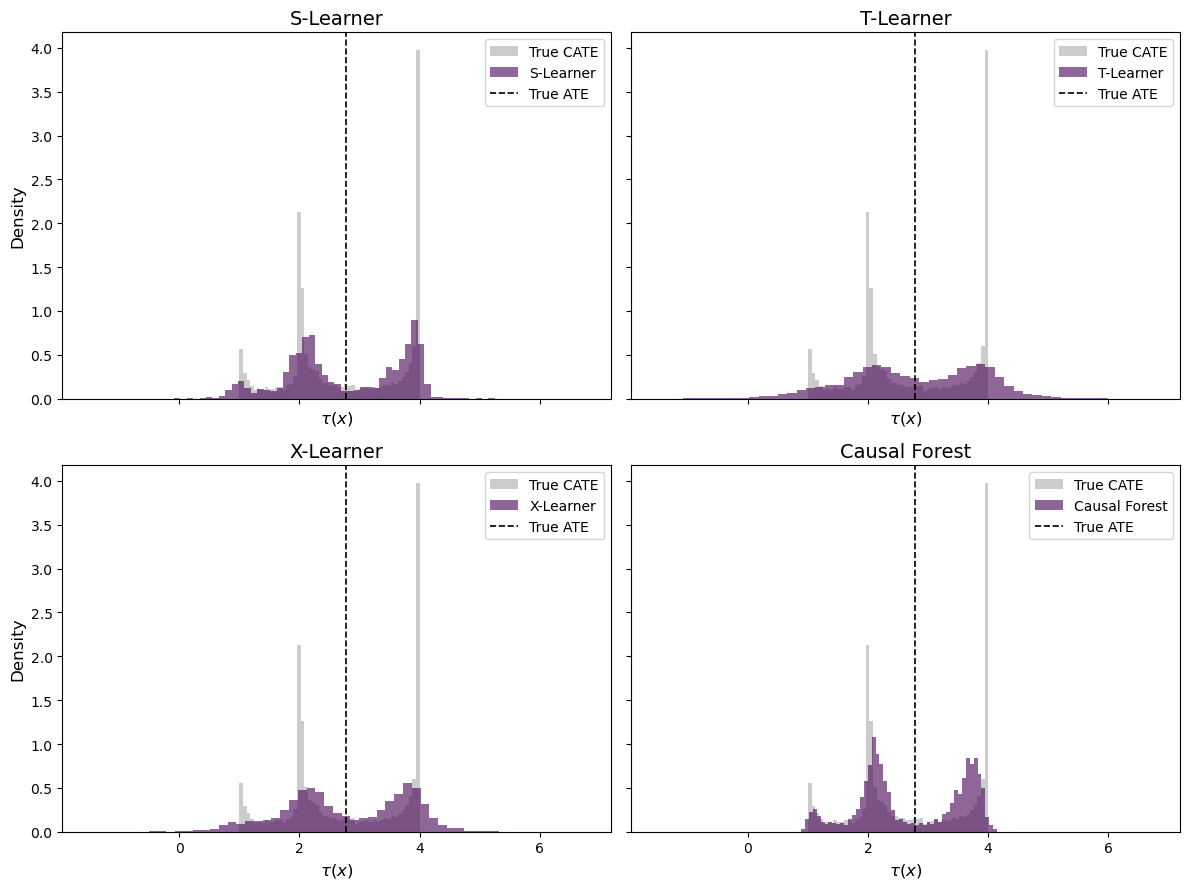

In [51]:
#| label: fig-cate-distribution
#| fig-cap: "Distribution of estimated CATEs vs. the true CATE distribution. The vertical dashed line marks the true ATE."
#| code-fold: true

fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharey=True, sharex=True)
axes = axes.flatten()

estimator_results = [
    ('S-Learner', tau_hat_s),
    ('T-Learner', tau_hat_t),
    ('X-Learner', tau_hat_x),
    ('Causal Forest', tau_hat_cf),
]

for ax, (name, tau_hat) in zip(axes, estimator_results):
    ax.hist(tau_true, bins=50, alpha=0.4, color='gray', label='True CATE', density=True)
    ax.hist(tau_hat, bins=50, alpha=0.6, color='#440154', label=f'{name}', density=True)
    ax.axvline(tau_true.mean(), color='black', linestyle='--', linewidth=1.2, label='True ATE')
    ax.set_xlabel('$\\tau(x)$', fontsize=12)
    ax.set_title(name, fontsize=14)
    ax.legend(fontsize=10)

axes[0].set_ylabel('Density', fontsize=12)
axes[2].set_ylabel('Density', fontsize=12)
plt.tight_layout()
plt.show()

The distribution plots in @fig-cate-distribution further illustrate the differences. The true CATE has a distinctive **bimodal shape** — a mass of observations near $\tau \approx 1$ (low $X_0$ or $X_1$) and another mass near $\tau \approx 4$ (both covariates above $1/3$).

The **S-Learner** and **Causal Forest** both recover this bimodal structure, though the Causal Forest distribution appears slightly more concentrated. The **T-Learner** produces the widest spread, with substantial probability mass outside the true range $[1, 4]$ — a consequence of its high variance. The **X-Learner** distribution shows an intermediate pattern, capturing the general shape but with heavier tails than the top-performing methods.

## 3.4. Sorted Treatment Effects

Finally, a useful way to evaluate CATE estimators is the **sorted treatment effect** plot: we sort individuals by their estimated CATE and compare against the true ranking. A well-calibrated estimator should produce a monotonically increasing curve that closely tracks the true sorted CATEs:

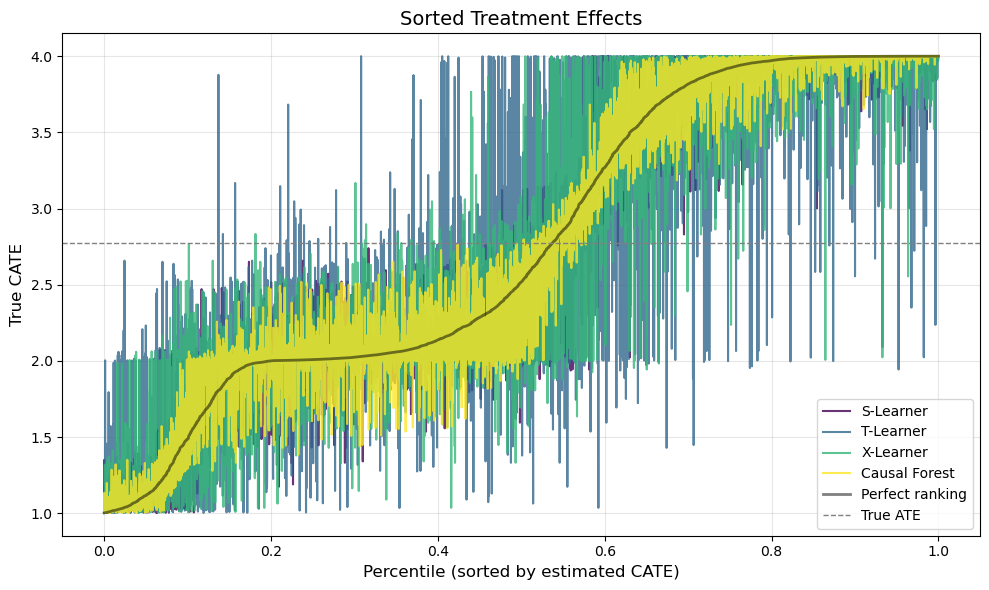

In [52]:
#| label: fig-sorted-effects
#| fig-cap: "Sorted treatment effects: individuals ranked by estimated CATE (x-axis) vs. their true CATE (colored lines). The gray dashed line shows the true ATE."
#| code-fold: true

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#440154', '#31688e', '#35b779', '#fde725']

for (name, tau_hat), color in zip(estimator_results, colors):
    sort_idx = np.argsort(tau_hat)
    ax.plot(
        np.arange(len(tau_hat)) / len(tau_hat),
        tau_true[sort_idx],
        label=name, color=color, alpha=0.8, linewidth=1.5
    )

# Perfect ranking (sorted by true CATE)
sort_true = np.argsort(tau_true)
ax.plot(
    np.arange(len(tau_true)) / len(tau_true),
    tau_true[sort_true],
    label='Perfect ranking', color='black', linestyle='-', linewidth=2, alpha=0.5
)

ax.axhline(tau_true.mean(), color='gray', linestyle='--', linewidth=1, label='True ATE')
ax.set_xlabel('Percentile (sorted by estimated CATE)', fontsize=12)
ax.set_ylabel('True CATE', fontsize=12)
ax.set_title('Sorted Treatment Effects', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

@fig-sorted-effects provides perhaps the most policy-relevant evaluation. In practice, we often want to use CATE estimates to **prioritize treatment** — e.g., targeting a marketing campaign at the customers who would benefit most. What matters, then, is not just the accuracy of the point estimates but whether the estimator correctly *ranks* individuals by their treatment effect.

The black line shows the **perfect ranking** — what we would get if we could observe $\tau(x)$ directly. A good estimator should produce a curve that closely tracks this oracle ranking. The S-Learner and Causal Forest both produce steep, monotonically increasing curves that nearly overlap with the perfect ranking, confirming their strong discriminative ability. The T-Learner curve is flatter and noisier, suggesting that its individual-level rankings are less reliable — a practitioner who used T-Learner estimates for targeting would misallocate treatment to a meaningful degree.

# 4. Application: E-Commerce Email Campaign

We now move from simulation to a **real-world randomized experiment**. The [Hillstrom Email Marketing dataset](https://blog.minethatdata.com/2008/03/minethatdata-e-mail-analytics-and-data.html) contains data from Kevin Hillstrom's MineThatData blog, where 64,000 customers of an online retailer were randomly assigned to one of three groups:

- **Men's Email**: received an email campaign featuring men's merchandise.
- **Women's Email**: received an email campaign featuring women's merchandise.
- **No Email** (control): received no email.

The primary outcome is whether the customer **visited the website** within two weeks of the email. The dataset includes customer-level covariates such as purchase history, recency, and channel preference — all features that a marketing team would plausibly use to **target** campaigns.

The key question shifts from *"does the email work on average?"* to: **"which customers respond most to the email, and should we target everyone — or only a subset?"**

## 4.1. Data

In [53]:
#| label: tbl-hillstrom
#| tbl-cap: Hillstrom Email Marketing Dataset

from sklift.datasets import fetch_hillstrom

# Load data
bundle = fetch_hillstrom()
df = bundle['data'].copy()
df['visit'] = bundle['target'].values
df['segment'] = bundle['treatment'].values

# Binarize treatment: Email (Men's or Women's) vs. No Email
df['W'] = (df['segment'] != 'No E-Mail').astype(int)

# Encode categorical variables
df['channel_web'] = (df['channel'] == 'Web').astype(int)
df['channel_multichannel'] = (df['channel'] == 'Multichannel').astype(int)
df['zip_suburban'] = (df['zip_code'] == 'Surburban').astype(int)
df['zip_rural'] = (df['zip_code'] == 'Rural').astype(int)

# Feature matrix
feature_cols = ['recency', 'history', 'mens', 'womens', 'newbie',
                'channel_web', 'channel_multichannel', 'zip_suburban', 'zip_rural']

X_h = df[feature_cols].values
W_h = df['W'].values
Y_h = df['visit'].values

print(f"Sample size: {len(df):,}")
print(f"Treated (any email): {W_h.sum():,} ({W_h.mean():.1%})")
print(f"Control (no email):  {(1-W_h).sum():,.0f} ({1-W_h.mean():.1%})")
print(f"Visit rate — Email: {Y_h[W_h==1].mean():.3f} | No Email: {Y_h[W_h==0].mean():.3f}")
print(f"Naive ATE: {Y_h[W_h==1].mean() - Y_h[W_h==0].mean():.4f}")
print()
df[feature_cols + ['W', 'visit']].head(8)

Sample size: 64,000
Treated (any email): 42,694 (66.7%)
Control (no email):  21,306 (33.3%)
Visit rate — Email: 0.167 | No Email: 0.106
Naive ATE: 0.0609



,recency,history,mens,womens,newbie,channel_web,channel_multichannel,zip_suburban,zip_rural,W,visit
0,10,142.44,1,0,0,0,0,1,0,1,0
1,6,329.08,1,1,1,1,0,0,1,0,0
2,7,180.65,0,1,1,1,0,1,0,1,0
3,9,675.83,1,0,1,1,0,0,1,1,0
4,2,45.34,1,0,0,1,0,0,0,1,0
5,6,134.83,0,1,0,0,0,1,0,1,1
6,9,280.20,1,0,1,0,0,1,0,1,0
7,9,46.42,0,1,0,0,0,0,0,1,0


The naive ATE tells us that the email campaign increases website visits by about 6 percentage points on average. Since this is a randomized experiment, this estimate is unbiased. But is it *the same* for all customers? If heterogeneity is strong enough, some customers may actually respond *negatively* to the email — and we would be better off not emailing them at all.

## 4.2. CATE Estimation

We apply the **Causal Forest** to the Hillstrom data. Since this performed best in our simulation study and — unlike the meta-learners — provides valid confidence intervals through the DML framework, it is the natural choice for a real-world application:

In [54]:
# Causal Forest on Hillstrom data
cf_h = CausalForestDML(
    model_y=GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42),
    model_t=GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42),
    n_estimators=500,
    min_samples_leaf=10,
    random_state=42,
)
cf_h.fit(Y_h, W_h, X=X_h)
tau_hat_h = cf_h.effect(X_h).flatten()

# Inference
ate_inference = cf_h.ate_inference(X=X_h)
ci_low, ci_high = ate_inference.conf_int_mean()
print(f"Causal Forest ATE: {np.asarray(ate_inference.mean_point).item():.4f}")
print(f"95% CI: [{np.asarray(ci_low).item():.4f}, {np.asarray(ci_high).item():.4f}]")
print(f"CATE range: [{tau_hat_h.min():.4f}, {tau_hat_h.max():.4f}]")
print(f"CATE std: {tau_hat_h.std():.4f}")

Causal Forest ATE: 0.0611
95% CI: [-0.0260, 0.1481]
CATE range: [-0.1221, 0.2448]
CATE std: 0.0444


## 4.3. Who Responds Most?

A key advantage of CATE estimation is that we can inspect **which customer characteristics drive treatment effect heterogeneity**. We do this in two ways: first, by looking at the distribution of estimated CATEs, and second, by examining how CATEs vary across observable subgroups.

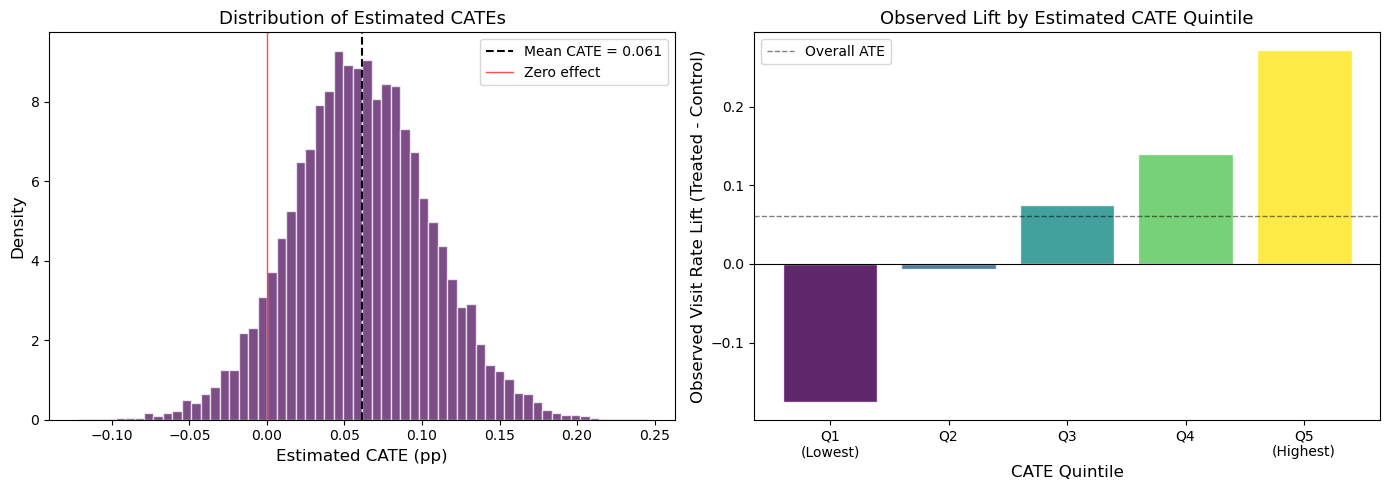

In [55]:
#| label: fig-cate-dist-hillstrom
#| fig-cap: "Distribution of estimated CATEs from the Causal Forest. Most customers experience a positive treatment effect, but there is meaningful heterogeneity."
#| code-fold: true

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(tau_hat_h, bins=60, color='#440154', alpha=0.7, edgecolor='white', density=True)
axes[0].axvline(tau_hat_h.mean(), color='black', linestyle='--', linewidth=1.5, label=f'Mean CATE = {tau_hat_h.mean():.3f}')
axes[0].axvline(0, color='red', linestyle='-', linewidth=1, alpha=0.7, label='Zero effect')
axes[0].set_xlabel('Estimated CATE (pp)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Distribution of Estimated CATEs', fontsize=13)
axes[0].legend(fontsize=10)

# CATE by quintile
df['cate'] = tau_hat_h
df['cate_quintile'] = pd.qcut(df['cate'], 5, labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Highest)'])

quintile_stats = df.groupby('cate_quintile', observed=True).agg(
    mean_cate=('cate', 'mean'),
    visit_treated=('visit', lambda x: x[df.loc[x.index, 'W'] == 1].mean()),
    visit_control=('visit', lambda x: x[df.loc[x.index, 'W'] == 0].mean()),
).reset_index()
quintile_stats['observed_lift'] = quintile_stats['visit_treated'] - quintile_stats['visit_control']

bars = axes[1].bar(quintile_stats['cate_quintile'], quintile_stats['observed_lift'],
                    color=['#440154', '#31688e', '#21918c', '#5ec962', '#fde725'],
                    edgecolor='white', alpha=0.85)
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].axhline(tau_hat_h.mean(), color='black', linestyle='--', linewidth=1, alpha=0.5, label='Overall ATE')
axes[1].set_xlabel('CATE Quintile', fontsize=12)
axes[1].set_ylabel('Observed Visit Rate Lift (Treated - Control)', fontsize=12)
axes[1].set_title('Observed Lift by Estimated CATE Quintile', fontsize=13)
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

The results are telling. The left panel of @fig-cate-dist-hillstrom shows that the estimated CATEs range from about $-0.12$ to $+0.24$ — a wide spread around the mean of $0.061$. Notably, a meaningful fraction of customers have *negative* estimated treatment effects: for these individuals, the email appears to **reduce** the probability of visiting the site (perhaps by triggering annoyance or unsubscribes).

The right panel provides a crucial **validation check**. We split customers into quintiles based on their *estimated* CATE, then compute the *observed* treatment effect within each quintile using the raw experimental data. If the Causal Forest is capturing real heterogeneity, we should see a monotonically increasing pattern — and the results are striking. Customers in Q1 (lowest estimated CATE) show a **negative observed lift** of roughly $-15$ pp, while those in Q5 experience an observed lift of nearly $+30$ pp. This strong monotonic gradient confirms that the Causal Forest is detecting genuine heterogeneity, not just fitting noise.

Now let's examine **which features** drive these differences:

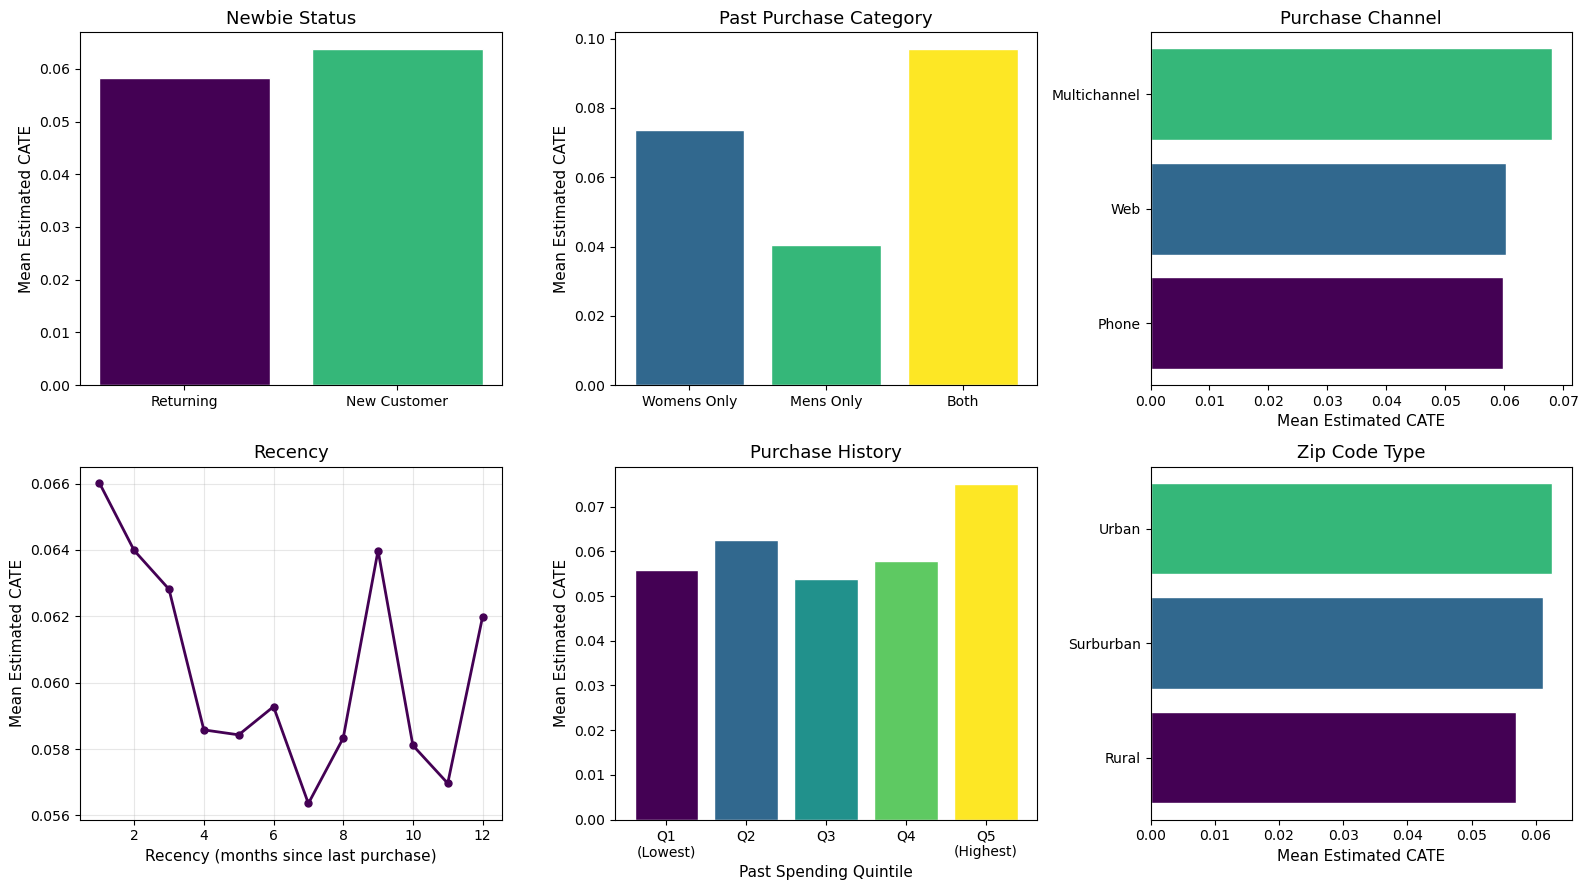

In [56]:
#| label: fig-subgroup-cate
#| fig-cap: "Average estimated CATE by customer subgroup. Cross-category shoppers, new customers, and recent buyers respond most to the email campaign."
#| code-fold: true

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()
palette = ['#440154', '#35b779']

# 1. Newbie vs Returning
ax = axes[0]
groups = df.groupby('newbie')['cate'].mean()
ax.bar(['Returning', 'New Customer'], groups.values, color=palette, edgecolor='white')
ax.set_title('Newbie Status', fontsize=13)
ax.set_ylabel('Mean Estimated CATE', fontsize=11)

# 2. Men's vs Women's past purchases
ax = axes[1]
labels = ['Neither', 'Womens Only', 'Mens Only', 'Both']
vals = [
    df[(df['mens']==0) & (df['womens']==0)]['cate'].mean(),
    df[(df['mens']==0) & (df['womens']==1)]['cate'].mean(),
    df[(df['mens']==1) & (df['womens']==0)]['cate'].mean(),
    df[(df['mens']==1) & (df['womens']==1)]['cate'].mean(),
]
ax.bar(labels, vals, color=['#440154', '#31688e', '#35b779', '#fde725'], edgecolor='white')
ax.set_title('Past Purchase Category', fontsize=13)
ax.set_ylabel('Mean Estimated CATE', fontsize=11)

# 3. Channel
ax = axes[2]
ch_groups = df.groupby('channel')['cate'].mean().sort_values()
ax.barh(ch_groups.index, ch_groups.values, color=['#440154', '#31688e', '#35b779'], edgecolor='white')
ax.set_title('Purchase Channel', fontsize=13)
ax.set_xlabel('Mean Estimated CATE', fontsize=11)

# 4. Recency
ax = axes[3]
rec_groups = df.groupby('recency')['cate'].mean()
ax.plot(rec_groups.index, rec_groups.values, 'o-', color='#440154', linewidth=2, markersize=5)
ax.set_xlabel('Recency (months since last purchase)', fontsize=11)
ax.set_ylabel('Mean Estimated CATE', fontsize=11)
ax.set_title('Recency', fontsize=13)
ax.grid(True, alpha=0.3)

# 5. History (spending)
ax = axes[4]
df['history_bin'] = pd.qcut(df['history'], 5, labels=['Q1\n(Lowest)', 'Q2', 'Q3', 'Q4', 'Q5\n(Highest)'])
hist_groups = df.groupby('history_bin', observed=True)['cate'].mean()
ax.bar(hist_groups.index, hist_groups.values,
       color=['#440154', '#31688e', '#21918c', '#5ec962', '#fde725'], edgecolor='white')
ax.set_xlabel('Past Spending Quintile', fontsize=11)
ax.set_ylabel('Mean Estimated CATE', fontsize=11)
ax.set_title('Purchase History', fontsize=13)

# 6. Zip Code
ax = axes[5]
zip_groups = df.groupby('zip_code')['cate'].mean().sort_values()
ax.barh(zip_groups.index, zip_groups.values, color=['#440154', '#31688e', '#35b779'], edgecolor='white')
ax.set_title('Zip Code Type', fontsize=13)
ax.set_xlabel('Mean Estimated CATE', fontsize=11)

plt.tight_layout()
plt.show()

@fig-subgroup-cate reveals several patterns in who responds most to the email:

- **Past purchase category** is the strongest driver of heterogeneity. Customers who previously bought from *both* men's and women's categories show a CATE nearly 2.5x higher than men's-only buyers (~10 pp vs. ~4 pp). This makes intuitive sense: cross-category shoppers may be more engaged with the brand overall, making them more receptive to marketing.
- **New customers** respond slightly more than returning ones, suggesting the email may be especially effective at re-engaging recent acquirers.
- **Recency** matters: customers who purchased most recently (1--2 months ago) show the highest CATEs, with a declining trend for more dormant customers. This aligns with the marketing intuition that recency is one of the strongest predictors of re-engagement.
- **Channel, zip code, and spending history** show more modest differences, with the highest spenders (Q5) and multichannel buyers slightly more responsive.

Together, these patterns suggest a clear **customer profile** for email targeting: recently acquired, cross-category shoppers with high engagement.

## 4.4. Targeting Policy: Who Should Receive the Email?

The ultimate value of CATE estimation is in designing **optimal targeting policies**. Instead of sending the email to *everyone* (which is what the firm did in the experiment), we can use the estimated CATEs to selectively target only those customers whose estimated treatment effect exceeds a threshold.

This is particularly relevant when the email has a cost (even if just an opportunity cost or risk of unsubscribes). The following plot shows what happens if we target only the **top $k\%$** of customers ranked by their estimated CATE, and compare the expected lift against the "treat everyone" baseline:

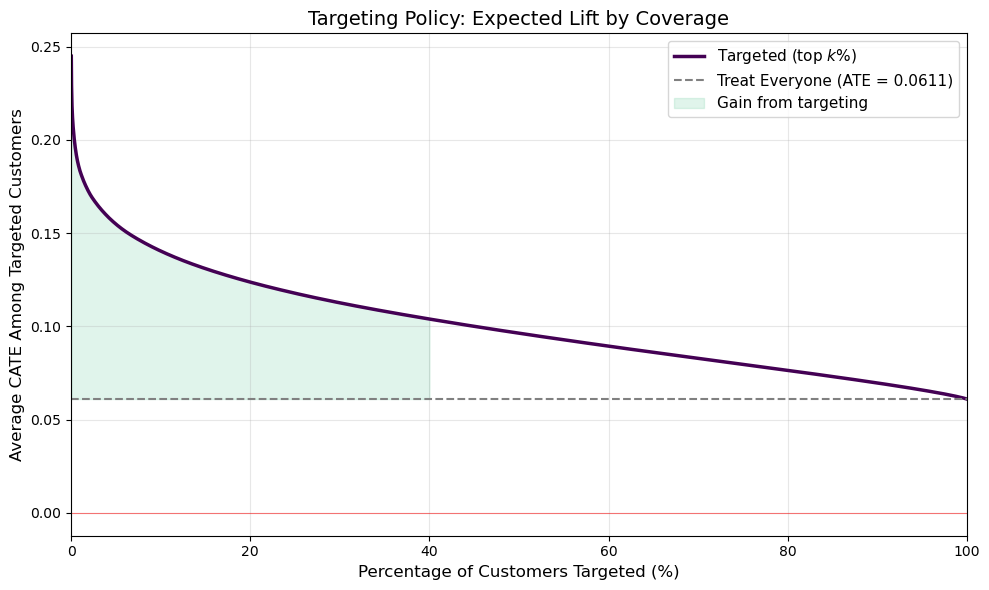

In [57]:
#| label: fig-targeting
#| fig-cap: "Targeting policy curve: expected treatment effect when emailing only the top $k\\%$ of customers, ranked by estimated CATE. Targeting the top 40% yields a higher average effect while reducing email volume by 60%."
#| code-fold: true

# Sort by estimated CATE (descending)
sort_idx = np.argsort(-tau_hat_h)
tau_sorted = tau_hat_h[sort_idx]

# Cumulative mean CATE as we include more customers
pct = np.arange(1, len(tau_sorted) + 1) / len(tau_sorted)
cumulative_mean = np.cumsum(tau_sorted) / np.arange(1, len(tau_sorted) + 1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(pct * 100, cumulative_mean, color='#440154', linewidth=2.5, label='Targeted (top $k$%)')
ax.axhline(tau_hat_h.mean(), color='gray', linestyle='--', linewidth=1.5, label=f'Treat Everyone (ATE = {tau_hat_h.mean():.4f})')
ax.axhline(0, color='red', linestyle='-', linewidth=0.8, alpha=0.5)

# Highlight optimal region
ax.fill_between(pct[:int(0.4*len(pct))] * 100, cumulative_mean[:int(0.4*len(pct))],
                tau_hat_h.mean(), alpha=0.15, color='#35b779', label='Gain from targeting')

ax.set_xlabel('Percentage of Customers Targeted (%)', fontsize=12)
ax.set_ylabel('Average CATE Among Targeted Customers', fontsize=12)
ax.set_title('Targeting Policy: Expected Lift by Coverage', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)
plt.tight_layout()
plt.show()

@fig-targeting illustrates the value of personalization. The gray dashed line shows the ATE from the "email everyone" strategy (6.1 pp). The purple curve shows the *average CATE among the top $k\%$* of customers. By targeting only the top 20% most responsive customers, the firm could achieve an average lift of roughly 15 pp — **more than double** the blanket approach — while sending 80% fewer emails.

Perhaps more importantly, the Q1 quintile in @fig-cate-dist-hillstrom showed a *negative* observed effect. By **excluding** the bottom ~20% of customers from the campaign, the firm avoids actively harming its relationship with customers who respond negatively to the email. This is the core promise of heterogeneity-aware targeting: **not just finding who to treat, but also who to leave alone**.

# 5. Conclusions

In this post, we explored modern methods for estimating **heterogeneous treatment effects** — moving beyond the average treatment effect to understand *who* benefits most from an intervention.

Key takeaways from our analysis:

1. **Causal Forests and the S-Learner performed best** in our simulation study, both achieving $R^2 > 0.95$ in recovering the true CATE surface. The T-Learner, while unbiased for the ATE, suffered from high variance in individual-level CATE estimation.

2. **The choice of method matters for downstream decisions**. The sorted treatment effect plot showed that estimator quality directly impacts the ability to *rank* individuals by their treatment response — a critical requirement for targeting policies.

3. **Applied to a real email marketing experiment**, the Causal Forest revealed meaningful heterogeneity that the ATE alone would miss. By estimating individual-level treatment effects, we were able to identify customer segments that respond most to the campaign and design a targeting policy that achieves higher per-customer impact with fewer emails.

The methods demonstrated here — particularly Causal Forests with double/debiased ML — are increasingly central to experimentation platforms at companies like Microsoft, Uber, and Spotify, where the question is no longer just "does it work?" but **"for whom does it work, and how should we act on that?"**

# References

- Athey, S., & Imbens, G. (2016). Recursive partitioning for heterogeneous causal effects. *Proceedings of the National Academy of Sciences*, 113(27), 7353-7360.
- Wager, S., & Athey, S. (2018). Estimation and inference of heterogeneous treatment effects using random forests. *Journal of the American Statistical Association*, 113(523), 1228-1242.
- Künzel, S. R., Sekhon, J. S., Bickel, P. J., & Yu, B. (2019). Metalearners for estimating heterogeneous treatment effects using machine learning. *Proceedings of the National Academy of Sciences*, 116(10), 4156-4165.
- Chernozhukov, V., et al. (2018). Double/debiased machine learning for treatment and structural parameters. *The Econometrics Journal*, 21(1), C1-C68.
- Hillstrom, K. (2008). The MineThatData E-Mail Analytics and Data Mining Challenge. [Blog post](https://blog.minethatdata.com/2008/03/minethatdata-e-mail-analytics-and-data.html).